In [1]:
import glob
import io
import math
import os
import scipy

from __future__ import print_function
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format


/home/arina/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv(
    io.open("/home/arina/Kenji_proj/Kinase/fullTab_desc_HRinter_solvEn.corr.3.tab", "r"), sep="\t")

np.random.seed(4)
df = df.reindex(np.random.permutation(df.index))
names = df['Compl']
df = df.drop('Compl',axis=1)

In [3]:
def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

In [4]:
for var in ['APF_score','minimizedAffinity','nof_Atoms',
            'vdw_i6_j12_s1_100_c8_','non_dir_h_bond_lj_o_0_7_100_c8_',
            'non_dir_anti_h_bond_quadratic_o0_c8_','repulsion_o0_c8_',
            'non_dir_h_bond_g_0_7_b0_c8_','donor_donor_quadratic_o0_c8_',
            'acceptor_acceptor_quadratic_o0_c8_','electrostatic_i2_100_c8_',
            'ad4_solvation_d_sigma3_6_s_q0_01097_c8_','sc1','sc2','sc3',
            'scCons','xEnergy','ICM_hbonds',
            'Seq_distance','Seq','APF_score','APF_sim',
            'H_bond','Hal_bond','Salt_Bridges','pi_Cation','pi_Stacking',
            'Seq','ICM_area','gauss_o0_w0_5_c8_',
            'hydrophobic_g0_5_b1_5_c8_','non_hydrophobic_g0_5_b1_5_c8_',
            'gauss_o3_w2_c8_','TOTAL_EELEC','TOTAL_SOLV', 'POLAR_SOLV', 
            'NONPOLAR_SOLV','COULOMB']:
    df[var] = z_score_normalize(df[var])


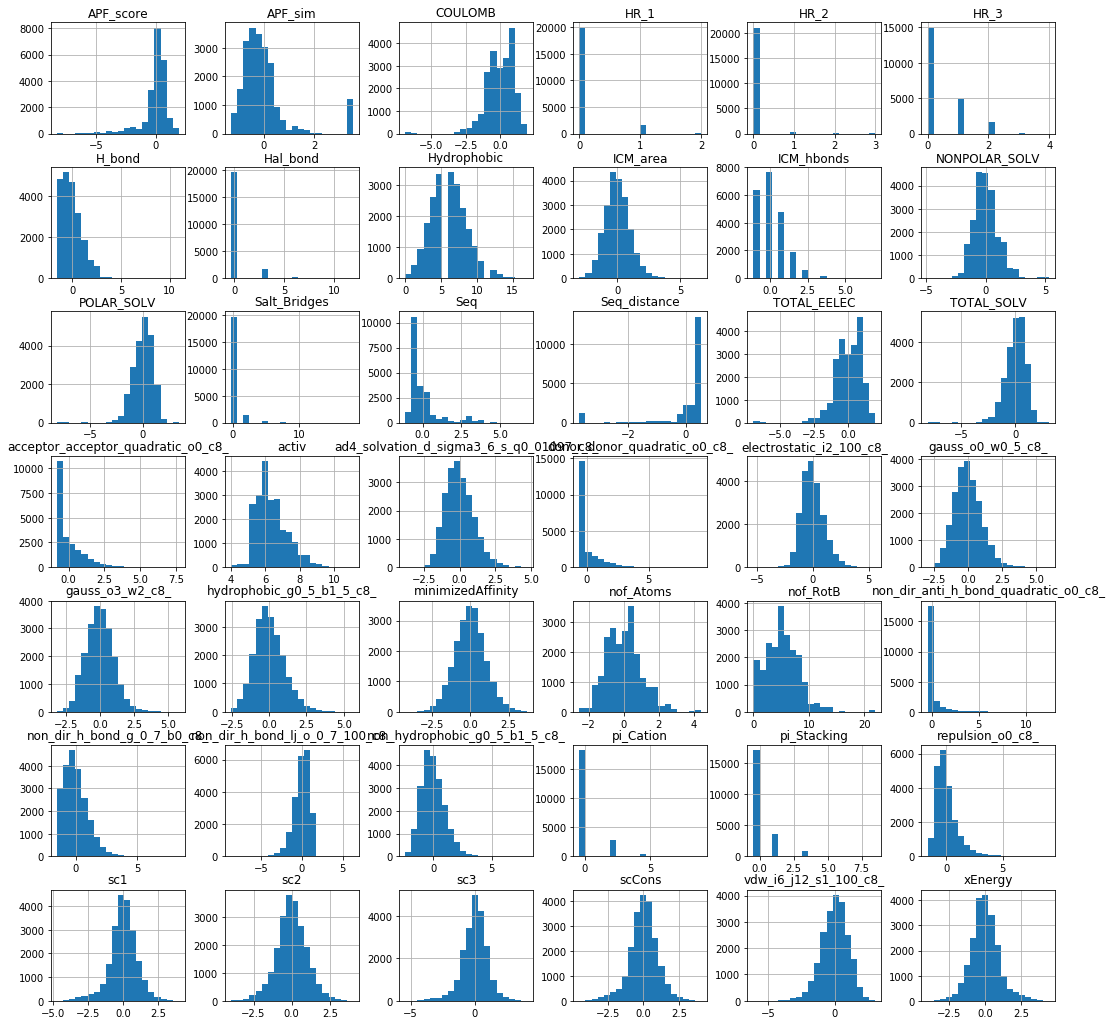

In [6]:
_ = df.hist(bins=20, figsize=(18, 18), xlabelsize=10)

In [7]:
cat_features=df[['Tar','HR_1','HR_2','HR_3']]
num_features=df.drop(cat_features, axis=1)
num_features=num_features.drop(['Comp','prTar'], axis=1)
all_feat=df.drop(['activ','Comp'],axis=1)

In [8]:
pdbs=set(df.Tar)

for feat in cat_features:
    df[feat] = pd.Categorical(df[feat])
    dfDummies = pd.get_dummies(df[feat], prefix = 'cat_'+str(feat))
    df = pd.concat([df, dfDummies], axis=1)
    df = df.drop(feat, axis=1)

for pdb in pdbs:
    newCol="cat_prTar_"+pdb
    df[newCol]=0
    
for pdb in pdbs:
    ii=df[df.prTar==pdb].index.tolist()
    col1='cat_prTar_' + str(pdb)
    df[col1][ii] = 1


/home/arina/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [9]:
df = df.drop("prTar", axis=1)

In [10]:
testComp=['v103905639','v103905539','v103905616','v103905521','v103905590','v103905503','v103904865','v103905107','v103905657','v103904504','v103905622','v103904925','v103904871','v103905673','v103905378']
testSet=df[df.Comp.isin(testComp)]
df=df[-df.Comp.isin(testComp)]
dfCompNames=df.Comp
testCompNames=testSet.Comp
df = df.drop('Comp',axis=1)
testSet = testSet.drop('Comp',axis=1)

y_train = df['activ'][:16000]
x_train = df.drop("activ", axis=1)[:16000]
y_test = df['activ'][16000:]
x_test = df.drop("activ", axis=1)[16000:]
y_testComp = testSet['activ'][:]
x_testComp = testSet.drop("activ", axis=1)[:]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_testComp.shape[0], 'test excluded compounds')


x_train shape: (16000, 258)
16000 train samples
5047 test samples
435 test excluded compounds


In [11]:
input_shape=(x_train.shape[1],)
input_shape

(258,)

In [12]:
df.describe()

,minimizedAffinity,ICM_hbonds,ICM_area,gauss_o0_w0_5_c8_,repulsion_o0_c8_,hydrophobic_g0_5_b1_5_c8_,non_hydrophobic_g0_5_b1_5_c8_,vdw_i6_j12_s1_100_c8_,non_dir_h_bond_lj_o_0_7_100_c8_,non_dir_anti_h_bond_quadratic_o0_c8_,...,cat_prTar_5JIX,cat_prTar_3FHR,cat_prTar_4GIH,cat_prTar_4NW6,cat_prTar_3VVH,cat_prTar_4TWC,cat_prTar_4HVD,cat_prTar_2X2M,cat_prTar_4GCJ,cat_prTar_2JDO
count,21047.0,21047.0,21047.0,21047.0,21047.0,21047.0,21047.0,21047.0,21047.0,21047.0,...,21047.0,21047.0,21047.0,21047.0,21047.0,21047.0,21047.0,21047.0,21047.0,21047.0
mean,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.1,0.0,0.1,0.0,0.2,0.1,0.0
min,-4.2,-1.1,-3.0,-2.9,-1.7,-2.6,-2.4,-6.1,-8.6,-0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-0.7,-1.1,-0.7,-0.7,-0.7,-0.7,-0.7,-0.6,-0.5,-0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,-0.0,-0.2,-0.1,-0.1,-0.2,-0.1,-0.1,0.0,0.1,-0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.6,0.7,0.6,0.6,0.4,0.6,0.6,0.7,0.7,-0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,3.7,7.0,6.7,5.9,9.1,5.6,8.0,3.1,6.3,12.5,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [13]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
best_mod = ModelCheckpoint('DNN-model-best.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
reg=0.00001
reg1=0.00001
drop=0.3

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=input_shape,
                kernel_regularizer=regularizers.l2(reg),
                activity_regularizer=regularizers.l1(reg1)))
model.add(Dropout(drop))
model.add(Dense(512, activation='relu',
                kernel_regularizer=regularizers.l2(reg),
                activity_regularizer=regularizers.l1(reg1)))
model.add(Dropout(drop))
model.add(Dense(512, activation='relu',
                kernel_regularizer=regularizers.l2(reg),
                activity_regularizer=regularizers.l1(reg1)))
model.add(Dropout(drop))
model.add(Dense(1, activation='relu'))


In [14]:
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])


In [15]:
batch_size = 10
epochs = 100

In [16]:
model1 = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[early_stop, best_mod])

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 16000 samples, validate on 5047 samples
Epoch 1/100
16000/16000 [==============================] - 13s 826us/step - loss: 1.5575 - mean_squared_error: 1.5138 - val_loss: 0.6949 - val_mean_squared_error: 0.6535

Epoch 00001: val_loss improved from inf to 0.69490, saving model to DNN-model-best.h5
Epoch 2/100
16000/16000 [==============================] - 13s 787us/step - loss: 0.8976 - mean_squared_error: 0.8631 - val_loss: 0.5376 - val_mean_squared_error: 0.5095

Epoch 00002: val_loss improved from 0.69490 to 0.53755, saving model to DNN-model-best.h5
Epoch 3/100
16000/16000 [==============================] - 13s 795us/step - loss: 0.6667 - mean_squared_error: 0.6401 - val_loss: 0.5433 - val_mean_squared_error: 0.5172

Epoch 00003: val_loss did not improve
Epoch 4/100
16000/16000 [==============================] - 13s 794us/step - loss: 0.6313 - mean_squared_error: 0.6052 - val_loss: 0.5305 - val_mean_squared_error: 0.5044

Epoch 00004: val_loss improved from 0.53755 to 0.5304

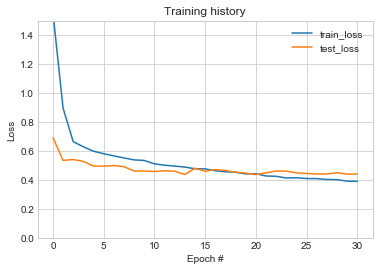

In [17]:
H = model1.history

N = np.arange(0, len(H["loss"]))
plt.style.use("seaborn-whitegrid")
plt.figure()
plt.plot(N, H["loss"], label="train_loss")
plt.plot(N, H["val_loss"], label="test_loss")
plt.title("Training history")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.ylim((0,1.5))
plt.legend()



In [18]:
model.load_weights("DNN-model-best.h5")


In [19]:
import scipy.stats
tr_prediction = model.predict(np.array(x_train))
tr_prediction = np.squeeze(tr_prediction, axis=(1,))
y_train=np.array(y_train)

print(scipy.stats.pearsonr(tr_prediction, y_train) )

(0.8151549215624677, 0.0)


In [20]:
val_prediction = model.predict(np.array(x_test))
val_prediction = np.squeeze(val_prediction, axis=(1,))
y_test=np.array(y_test)

print(scipy.stats.pearsonr(val_prediction, y_test) )

(0.7197363250881337, 0.0)


In [21]:
test_prediction = model.predict(np.array(x_testComp))
test_prediction = np.squeeze(test_prediction, axis=(1,))
y_testComp=np.array(y_testComp)

print(scipy.stats.pearsonr(test_prediction, y_testComp) )

(0.4146965589699695, 1.6505953534604172e-19)


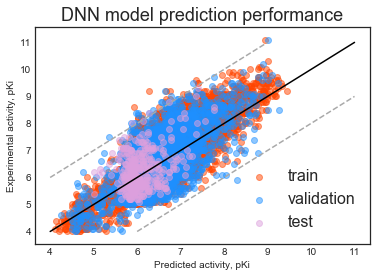

In [22]:
plt.style.use("seaborn-white")
plt.scatter(tr_prediction, y_train, alpha=0.5, color='orangered', label='train')
plt.scatter(val_prediction, y_test, alpha=0.5, color='dodgerblue',label='validation')
plt.scatter(test_prediction, y_testComp, alpha=0.5, color='plum', label='test')
plt.plot([4,11], [4,11], c='black')
plt.plot([6,11], [4,9], c='darkgrey', ls='dashed')
plt.plot([4,9], [6,11], c='darkgrey', ls='dashed')
plt.legend(loc='lower right', fontsize=16)
plt.title("DNN model prediction performance", fontsize=18)
plt.xlabel("Predicted activity, pKi")
plt.ylabel("Experimental activity, pKi")
plt.show()

In [23]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [24]:
rmse(tr_prediction, y_train)

0.5466360444378267

In [25]:
rmse(val_prediction, y_test)

0.6394348382326932

In [26]:
rmse(test_prediction, y_testComp)

0.6624118118727311

In [27]:
%matplotlib inline 
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm.libsvm import cross_validation
from sklearn.model_selection import cross_val_score
from sklearn.learning_curve import validation_curve

num_to_try = [5,10,25,50,75,100,200,400,800]
train_scores, valid_scores = validation_curve(RandomForestRegressor(), 
                                              x_train,y_train, 
                                              "n_estimators",
                                               num_to_try, n_jobs=-1)


/home/arina/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/arina/miniconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


Text(0,0.5,'R_square')

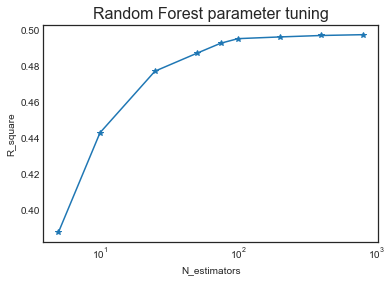

In [29]:
plt.style.use("seaborn-white")
plt.figure()
plt.plot(num_to_try, np.mean(valid_scores, axis=1),"-*")
plt.xscale("log")
plt.title("Random Forest parameter tuning", fontsize=16)
plt.xlabel("N_estimators")
plt.ylabel("R_square")

In [30]:
rf_model = RandomForestRegressor(n_estimators=300)
rf_model = rf_model.fit(x_train,y_train)

scores = cross_val_score(rf_model, x_train,y_train, cv=3, n_jobs=-1)
print("accuracies     = ",scores)
print("mean accuracy = %4.2f" % (scores.mean()))


accuracies     =  [0.50356146 0.50530249 0.47956274]
mean accuracy = 0.50


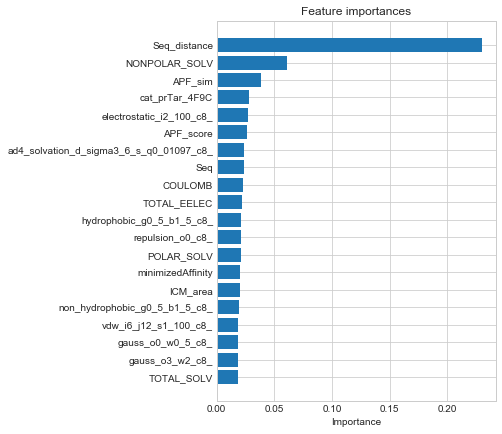

In [31]:
features_list = x_train.columns.values
feature_importance = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1][:20][::-1]

plt.style.use("seaborn-whitegrid")
plt.figure(figsize=(5,7))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importances')
plt.draw()
plt.show()

In [32]:
tr_prediction_rf = rf_model.predict(np.array(x_train))
y_train=np.array(y_train)

print(scipy.stats.pearsonr(tr_prediction_rf, y_train) )

(0.9779527720111445, 0.0)


In [33]:
val_prediction_rf = rf_model.predict(np.array(x_test))
y_test=np.array(y_test)

print(scipy.stats.pearsonr(val_prediction_rf, y_test) )

(0.7271765311087576, 0.0)


In [34]:
test_prediction_rf = rf_model.predict(np.array(x_testComp))
y_testComp=np.array(y_testComp)

print(scipy.stats.pearsonr(test_prediction_rf, y_testComp) )

(0.42269268718603653, 2.79336145643839e-20)


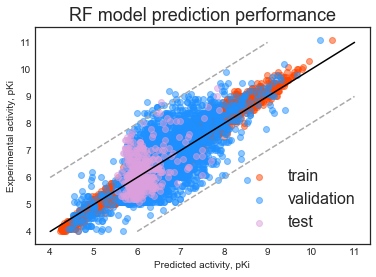

In [35]:
plt.style.use("seaborn-white")
plt.scatter(tr_prediction_rf, y_train, alpha=0.5, color='orangered', label='train')
plt.scatter(val_prediction_rf, y_test, alpha=0.5, color='dodgerblue',label='validation')
plt.scatter(test_prediction_rf, y_testComp, alpha=0.5, color='plum', label='test')
plt.plot([4,11], [4,11], c='black')
plt.plot([6,11], [4,9], c='darkgrey', ls='dashed')
plt.plot([4,9], [6,11], c='darkgrey', ls='dashed')
plt.legend(loc='lower right', fontsize=16)
plt.title("RF model prediction performance", fontsize=18)
plt.xlabel("Predicted activity, pKi")
plt.ylabel("Experimental activity, pKi")
plt.show()


In [36]:
rmse(tr_prediction_rf, y_train)

0.23371196400282007

In [37]:
rmse(val_prediction_rf, y_test)

0.6315083215505322

In [38]:
rmse(test_prediction_rf, y_testComp)

0.6464849021714519

In [39]:
from sklearn.externals import joblib
joblib.dump(rf_model, 'RF_model.pkl') 

['RF_model.pkl']

In [40]:
model_json = model.to_json()
with open("DNN_model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
plt.style.use("seaborn-white")
plt.hist(df.activ, color='steelblue')
plt.title("Distribution of pKi values in dataset", fontsize=16)
plt.ylabel("Count")
plt.xlabel("Activity, pKi")
plt.show()